# Entrenamiento de un árbol de decisión

En esta hoja de trabajo veremos como elegir los mejores hiperparámetros para entrenar a un árbol de decisiones, así como entrenar al propio árbol y ver si los hiperparámetros elegidos dan un buen rendimiento.

Empezaremos importando las librerias y funciones que utilizaremos más adelante.

In [1]:
import pandas as pd
import numpy as np
np.random.seed(220718)
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import confusion_matrix, recall_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from matplotlib import pyplot
from sklearn.tree import plot_tree

# Lectura de datos y creación de los atributos y el objetivo

Vamos a empezar por importar el dataset con todos lo atributos que calculamos para la realización de este trabajo. Luego separamos el dataset en atributos por los cuales el árbol se va a entrenar, estos a su vez lo separamos en discretos y continuos para tratarlos mas adelante. Y por último elegiremos el objetivo, en este caso es un objetivo categórico binario.

In [2]:
# Lectura del csv para la tabla con todas las métricas
nodes = pd.read_csv("../tablas/tableWithAllAtributes.csv")
nodes.head()

,id_node,name,ml_target,degree_centrality,closeness_centrality,betweenness_centrality,clustering_coefficient,Square clustering,triangles,greedy_modularity_communities,Core number,asyn_lpa_communities
0,0,Eiryyy,0.0,0.000027,0.275005,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,1,shawflying,0.0,0.000212,0.294956,1.149733e-06,0.178571,0.072344,0.000062,0.002227,0.151515,0.0
2,2,JpMCarrilho,1.0,0.000027,0.261845,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,3,SuhwanCha,0.0,0.000133,0.278718,5.316292e-05,0.000000,0.019178,0.000000,0.004454,0.090909,0.0
4,4,sunilangadi2,1.0,0.000053,0.243084,6.134318e-09,0.000000,0.000000,0.000000,0.011136,0.030303,0.0


In [3]:
# Preparación de los datos para la tabla con todos los atributos
atributos_discretos = ['name']
atributos_continuos = ['degree_centrality','closeness_centrality','betweenness_centrality','clustering_coefficient','Square clustering','triangles','greedy_modularity_communities','Core number','asyn_lpa_communities']
atributos = nodes.loc[:,['id_node'] + atributos_discretos + atributos_continuos]
atributos.head()

,id_node,name,degree_centrality,closeness_centrality,betweenness_centrality,clustering_coefficient,Square clustering,triangles,greedy_modularity_communities,Core number,asyn_lpa_communities
0,0,Eiryyy,0.000027,0.275005,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,1,shawflying,0.000212,0.294956,1.149733e-06,0.178571,0.072344,0.000062,0.002227,0.151515,0.0
2,2,JpMCarrilho,0.000027,0.261845,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,3,SuhwanCha,0.000133,0.278718,5.316292e-05,0.000000,0.019178,0.000000,0.004454,0.090909,0.0
4,4,sunilangadi2,0.000053,0.243084,6.134318e-09,0.000000,0.000000,0.000000,0.011136,0.030303,0.0


In [4]:
# Elección del objetivo
objetivo = nodes['ml_target']
objetivo.head()

0    0.0
1    0.0
2    1.0
3    0.0
4    1.0
Name: ml_target, dtype: float64

# Tratamiento de los datos

Vamos a tener que codificar la columna name, ya que los árboles de decisión no pueden trabajar directamente con cadenas de texto. Para ello, utilizaremos la siguiente función para convertir las cadenas en números y luego normalizaremos esos números entre 0 y 1, tomando el máximo y el mínimo para la normalización.

In [5]:
# Codificación
codificador_atributos_discretos = OrdinalEncoder() # Crear una instancia de la clase correspondiente
codificador_atributos_discretos.fit(atributos[atributos_discretos]) # Usar el método fit para ajustar a los datos los parámetros de la codificación

# Vemos información sobre los atributos discretos
print("///Información sobre los atributos discretos///")
print('Número de atributos detectados:',
      f'{codificador_atributos_discretos.n_features_in_}')
print()
print('Nombres de los atributos detectados:')
print(f'{codificador_atributos_discretos.feature_names_in_}')
print()
print('Categorías detectadas de cada atributo:')
for atributo, categorías in zip(
    codificador_atributos_discretos.feature_names_in_,
    codificador_atributos_discretos.categories_):
    print(f'{atributo}: {categorías}')

# Ahora aplicamos el método transform para codificar los datos
atributos[atributos_discretos] = codificador_atributos_discretos.transform(
    atributos[atributos_discretos]
)


# Normalizamos el name
normalizador = MinMaxScaler(
    # Cada atributo se normaliza al intervalo [0, 1]
    feature_range=(0, 1)
)


# Aplicamos la normalización solo a la columna 'name'
atributos['name'] = normalizador.fit_transform(atributos[['name']])

print()
print("///Tabla con la columna name codificada y normalizada///")
atributos.head()


///Información sobre los atributos discretos///
Número de atributos detectados: 1

Nombres de los atributos detectados:
['name']

Categorías detectadas de cada atributo:
name: ['007arunwilson' '007jedgar' '00Kai0' ... 'timothykimemia' 'timoxley'
 'timqian']

///Tabla con la columna name codificada y normalizada///


,id_node,name,degree_centrality,closeness_centrality,betweenness_centrality,clustering_coefficient,Square clustering,triangles,greedy_modularity_communities,Core number,asyn_lpa_communities
0,0,0.061673,0.000027,0.275005,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,1,0.929866,0.000212,0.294956,1.149733e-06,0.178571,0.072344,0.000062,0.002227,0.151515,0.0
2,2,0.106687,0.000027,0.261845,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,3,0.191517,0.000133,0.278718,5.316292e-05,0.000000,0.019178,0.000000,0.004454,0.090909,0.0
4,4,0.969442,0.000053,0.243084,6.134318e-09,0.000000,0.000000,0.000000,0.011136,0.030303,0.0


# Elección de hiperparámetros

Vamos a elegir los mejores hiperparámetros para entrenar nuestro árbol de decisión, para ello vamos a utilizar la busqueda en rejilla, donde va hacer combinación entre que la máxima profundidad sea de 3 a 10 y que el mínimo número de ejemplos por el cual puede particionar es 5, 10 ó 15.

Como verás más adelante nos da que el árbol debería tener una profundidad de 5 nodos y que como mínimo debemos particionar con 5 ejemplos.

In [6]:
clasificador_CART = DecisionTreeClassifier()
rejilla_de_hiperparámetros = {
    # Máxima profundidad del árbol: 3, 4, 5, 6, 7, 8, 9, 10
    'max_depth': range(3, 11),
    # Mínimo número de ejemplos para poder particionar: 5, 10, 15
    'min_samples_split': range(5, 16, 5)
}

In [7]:
búsqueda_en_rejilla = GridSearchCV(clasificador_CART,
                                   rejilla_de_hiperparámetros,
                                   scoring='recall',
                                   cv=10)
búsqueda_en_rejilla.fit(atributos, objetivo)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': range(3, 11),
                         'min_samples_split': range(5, 16, 5)},
             scoring='recall')

In [8]:
búsqueda_en_rejilla.best_params_

{'max_depth': 5, 'min_samples_split': 5}

In [9]:
búsqueda_en_rejilla.best_score_

0.5754264526190722

# Validación por retención

Ahora vamos a comprobar si los resultados de la busqueda en rejilla son acertados, para ello vamos a dividir el dataset en datos de entrenamiento y datos de pruebas, en este caso vamos a dividir en un 80% de los datos para entrenar y un 20% para comprobar cómo se ha entrenado.

Para ello vamos a entrenar varios árboles, cambiando los hiperparámetros y ver cual nos da un mejor rendimiento y luego analizaremos qué significan esos rendimientos.

In [10]:
# Dividimos los conjuntos de prueba y entrenamiento
(atributos_entrenamiento, atributos_prueba,
 objetivo_entrenamiento, objetivo_prueba) = train_test_split(
        # Conjuntos de datos a dividir, usando los mismos índices para ambos
        atributos, objetivo,
        # Tamaño del conjunto de prueba (20 % en este caso)
        test_size=.2,
        # Estratificación según la distribución de clases en el atributo objetivo
        stratify=objetivo,
        random_state=220718)

In [11]:
# CART de 3 y 3
clasificador_CART = DecisionTreeClassifier(
    max_depth=3,  # Máxima profundidad del árbol
    min_samples_split=3  # Mínimo número de ejemplos para poder particionar
)
clasificador_CART.fit(atributos_entrenamiento, objetivo_entrenamiento)

DecisionTreeClassifier(max_depth=3, min_samples_split=3)

In [12]:
predicciones = clasificador_CART.predict(atributos_prueba)

In [13]:
cm = confusion_matrix(objetivo_prueba, predicciones)
tabla_cm = pd.DataFrame(cm, index=["Verdadero Negativo", "Verdadero Positivo"], columns=["Predicho Negativo", "Predicho Positivo"])
print(tabla_cm)

                    Predicho Negativo  Predicho Positivo
Verdadero Negativo               5095                497
Verdadero Positivo                852               1096


In [14]:
recall_score(objetivo_prueba,predicciones)

0.6880100439422473

In [15]:
# CART de 10 y 10
clasificador_CART = DecisionTreeClassifier(
    max_depth=10,  # Máxima profundidad del árbol
    min_samples_split=10  # Mínimo número de ejemplos para poder particionar
)
clasificador_CART.fit(atributos_entrenamiento, objetivo_entrenamiento)

DecisionTreeClassifier(max_depth=10, min_samples_split=10)

In [16]:
predicciones = clasificador_CART.predict(atributos_prueba)

In [17]:
recall_score(predicciones, objetivo_prueba)

0.6765273311897106

In [18]:
cm = confusion_matrix( objetivo_prueba,predicciones)
tabla_cm = pd.DataFrame(cm, index=["Verdadero Positivo", "Verdadero Negativo"], columns=["Predicho Positivo", "Predicho Negativo"])
print(tabla_cm)

                    Predicho Positivo  Predicho Negativo
Verdadero Positivo               5089                503
Verdadero Negativo                896               1052


In [19]:
# CART de 5 y 5
clasificador_CART = DecisionTreeClassifier(
    max_depth=5,  # Máxima profundidad del árbol
    min_samples_split=5  # Mínimo número de ejemplos para poder particionar
)
clasificador_CART.fit(atributos_entrenamiento, objetivo_entrenamiento)

DecisionTreeClassifier(max_depth=5, min_samples_split=5)

In [20]:
predicciones = clasificador_CART.predict(atributos_prueba)

In [21]:
cm = confusion_matrix(objetivo_prueba, predicciones)
tabla_cm = pd.DataFrame(cm, index=["Verdadero Positivo", "Verdadero Negativo"], columns=["Predicho Positivo", "Predicho Negativo"])
print(tabla_cm)

                    Predicho Positivo  Predicho Negativo
Verdadero Positivo               5130                462
Verdadero Negativo                867               1081


In [22]:
recall_score(objetivo_prueba, predicciones)

0.5549281314168378

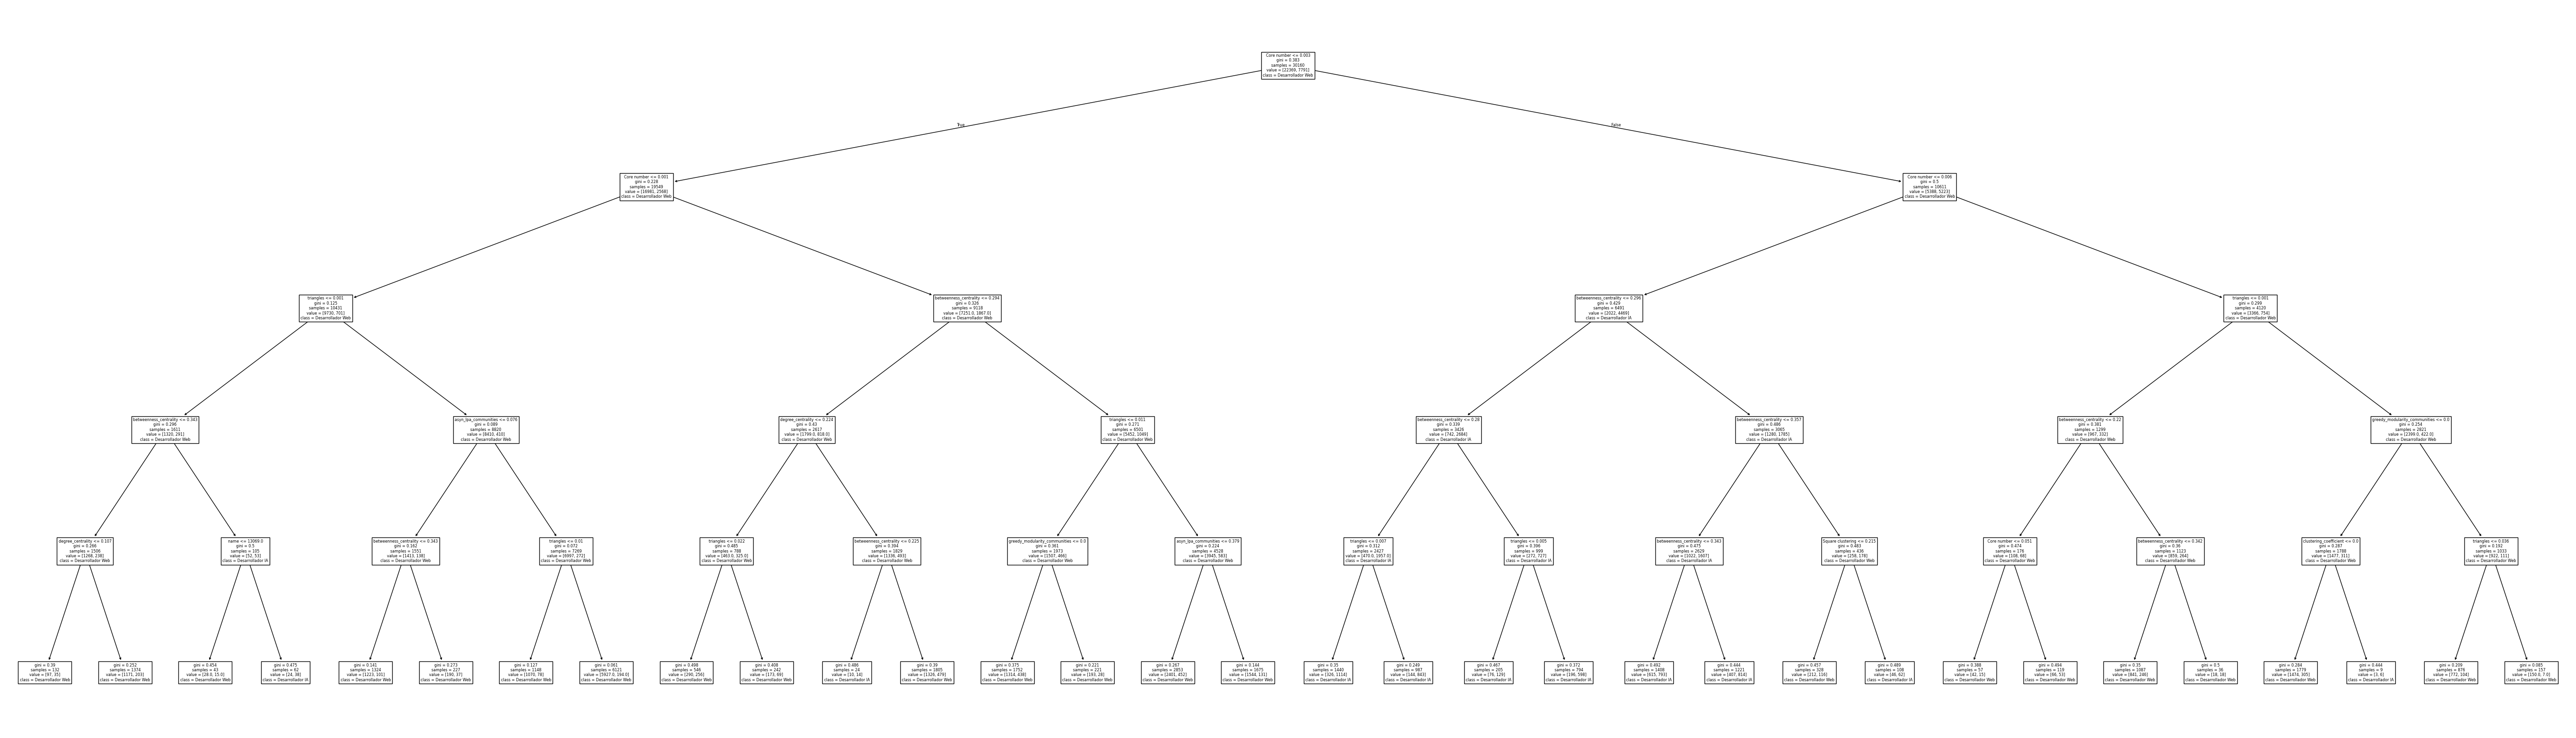

In [23]:
pyplot.figure(figsize=(70, 20))  # Anchura y altura del gráfico
árbol = plot_tree(clasificador_CART,
                  # El argumento feature_names permite proporcionar, en una
                  # lista, los nombres de los atributos.
                  feature_names=atributos_discretos + atributos_continuos,
                  # El argumento class_names permite proporcionar, en una
                  # lista, los nombres de las clases
                  class_names=['Desarrollador Web', 'Desarrollador IA'])

# Análisis del resultado

Al considerar nuestros resultados, observamos que el mejor puntaje se logra al establecer un máximo de 5 nodos y una partición mínima con 5 ejemplos. Esto nos proporciona una confianza del 0.5549281314168378. Dado que en nuestros datos el 75% corresponde a desarrolladores web y el 25% a desarrolladores de IA, al examinar la matriz de confusión, podemos concluir que el árbol de decisiones funciona mejor que un clasificador aleatorio. Aunque hay una cantidad significativa de falsos positivos, esto podría deberse a la escasez de ejemplos de desarrolladores de IA en la partición, lo que sugiere que el modelo tiene un rendimiento aceptable dadas las condiciones de partición.